## Install Necessary Libraries

In [ ]:
!sudo apt install -y fluidsynth

In [ ]:

!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

In [ ]:
import os
import json
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

from google.colab import drive

# suppress scientific notation
np.set_printoptions(suppress=True)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Background
---
webpage: https://zenodo.org/record/5257995

### Russel's 4 Quadrants (4Qs)
A way of categorizing emotion along the dimensions of Valence and Arousal. This splits the emotion space into 4 quadrants/ categories. These categories are as follows:
<ul>
  <li>High Valence High Arousal (HVHA)</li>
  <li>High Valence Low Arousal (HVLA)</li>
  <li>Low Valence High Arousal (LVHA)</li>
  <li>Low Valence Low Arousal (LVLA)</li>
</ul>
<br></br>
As seen below, we can split
<br></br>

![Russels 4Qs!](https://www.researchgate.net/publication/332330025/figure/fig1/AS:746153582800898@1554908285595/Russells-circumspect-model-adapted-from-4.jpg)
<br></br>
<br></br>
Citations:
<ul>
  <li>https://www.researchgate.net/figure/Russells-circumspect-model-adapted-from-4_fig1_332330025</li>
  <li>https://iopscience.iop.org/article/10.1088/1757-899X/482/1/012019/pdf</li>
  <li>Dataset: https://zenodo.org/record/5257995</li>
</ul>
<br></br>

## About the dataset
This dataset comes from the Zenodo webpage. It contains 1087 clips from individual 387 songs scrapped from YouTube. Each clip can be annotated with Russel's 4Qs; providing data about the emotion of the song.

With this dataset, one can either perform Emotion Classification tasks or Music Generation tasks.
<br></br>
###Dataset file format: <br>
---
**midi**: the songs in Midi format <br>
**metadata**: data about each file, held in JSON format. The file contains information such as The name of the song, the person that uploaded the song on youtube, the number of likes/ dislikes of a song, and the URL of the song <br>
**label.csv**: a table providing the name and emotion label of each song <br>
**key_mode_tempo.csv**: a table providing the name, key, tempo and emotion label of each song


Naming conventions for MIDI file names:
<ul>
  <li>format: Q#_xxxxxxx_#.mp3</li>
  <ul>
    <li>Q#: stands for the Russel 4Qs classification of each clip</li>
    <li>xxxxxxx: the YouTube id of a song</li>
    <li>#: the partition number of a song. For example, the number 3 would indicate that the file is the 3rd clip of a given song.</li>
  </ul>
  <li>placeholder</li>
</ul>


In [ ]:
"""
All the files use one instrument which is "Acoustic Grand Piano"
"""

pm = pretty_midi.PrettyMIDI("/content/drive/MyDrive/Final Project/EMOPIA_2.1/midis/Q4_1vjy9oMFa8c_3.mid") # Sample file
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

print(instrument_name)

Acoustic Grand Piano


## Load the data
The following code was provided by the author of the dataset to split the data into train, test, and validation partitions.

In [ ]:
# load the data
# data_dir = '/content/drive/MyDrive/U of T Cont Studies/Deep Learning/Final Project/EMOPIA_2.1'
data_dir = '/content/drive/MyDrive/Final Project/EMOPIA_2.1'
meta_df = pd.read_csv(data_dir + '/metadata_by_song.csv')
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   songID      387 non-null    object
 1   num_Q1      387 non-null    int64 
 2   num_Q2      387 non-null    int64 
 3   num_Q3      387 non-null    int64 
 4   num_Q4      387 non-null    int64 
 5   DominantQ   387 non-null    int64 
 6   Unnamed: 6  387 non-null    int64 
 7   Unnamed: 7  1 non-null      object
dtypes: int64(6), object(2)
memory usage: 24.3+ KB


In [ ]:
# get a look at what the data looks like
meta_df.head()

songID  num_Q1  num_Q2  num_Q3  num_Q4  DominantQ  Unnamed: 6  \
0  e8NQ2NH0nc8       2       0       0       0          1           2   
1  HQ8ISDX6PiI       0       0       0       2          4           2   
2  ZTrEoB8T9YA       0       3       0       0          2           3   
3  3N2G21U7guk       3       0       0       4          4           7   
4  _8v0MFBZoco       2       0       0       0          1           2   

  Unnamed: 7  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

In [ ]:
# define how the data will be split into train, test and split samples
def get_samples(data, song_num=8, random_seed=1):
    '''
    Will return test data as an new dataframe.
    Random sample song_num songs from each Q,
    and the result of the number of clips will roughly be 1/10 in each Q.
    '''
    Q1 = data[data['DominantQ'] == 1]
    Q2 = data[data['DominantQ'] == 2]
    Q3 = data[data['DominantQ'] == 3]
    Q4 = data[data['DominantQ'] == 4]
    test_Q1 = Q1.sample(song_num, random_state=1)
    test_Q2 = Q2.sample(song_num, random_state=1)
    test_Q3 = Q3.sample(song_num, random_state=1)
    test_Q4 = Q4.sample(song_num, random_state=1)
    test_data = pd.concat([test_Q1, test_Q2, test_Q3, test_Q4])
    print('CLIPS PER SPLIT\n',test_data.sum(axis = 0), '\n\n')
    return test_data



# check the ratio of datasets
def count_ratio(nums, Q=1):
  """
  Determines the percent of samples in each data split.

  Parameters:
    nums (int): the number of samples in each dataset split
    Q (int): the emotional quadrant to sample clips from

  Returns:
    None
  """
  total = sum([x['num_Q'+str(Q)] for x in nums])
  print('TRAIN TEST SPLIT PERCENTAGES')
  print('train: {}'.format(nums[0]['num_Q'+ str(Q)] / total))
  print('val  : {}'.format(nums[1]['num_Q'+ str(Q)] / total))
  print('test : {}'.format(nums[2]['num_Q'+ str(Q)] / total))



def create_splits(df, num_test_samples = 8):
  """
  Split the data into train, validation and test indices.

  Parameter:
    num_test_samples (int): the number of samples to take from Russel Quandrant for a given split

  Returns:
    train_indices_df (Pandas.DataFrame): songs and number of clips in the training set
    val_indices_df (Pandas.DataFrame): songs and number of clips in the validation set
    test_indices_df (Pandas.DataFrame): songs and number of clips in the test set
  """
  # use song names as indices to sample for each split
  test_indices_df = get_samples(df, num_test_samples)
  train_val = df.drop(labels = test_indices_df.index, axis = 0, inplace = False)
  val_indices_df = get_samples(train_val, num_test_samples)
  train_indices_df = train_val.drop(labels = val_indices_df.index, axis = 0, inplace = False)

  #make sure there is no song overlap between train, val, test
  assert len(set(train_indices_df.index) & set(val_indices_df.index)) == 0
  assert len(set(train_indices_df.index) & set(test_indices_df.index)) == 0
  assert len(set(test_indices_df.index) & set(val_indices_df.index)) == 0

  # get the number of clips in each dataset
  train_num = train_indices_df.sum()
  val_num = val_indices_df.sum()
  test_num = test_indices_df.sum()

  nums = [train_num, val_num, test_num]
  count_ratio(nums, Q=1)
  return train_indices_df, val_indices_df, test_indices_df

In [ ]:
def train_test_clips(df, num_split_samples = 8):
  """
  Splits midi clips into train, validation, and test set.

  Parameters:
    num_split_samples (int): the number of samples to take from Russel Quandrant for a given split

  Returns:
    train_clips (list of str): file names of clips in the training set
    val_clips (list of str): file names of clips in the validation set
    test_clips (list of str): file names of clips in the test set
  """
  # the location of midi files
  midi_files = glob.glob(os.path.join(data_dir + '/midis', '*.mid'))

  # create the split of songs to each dataset
  df.set_index('songID', inplace=True)
  train_indices_df, val_indices_df, test_indices_df = create_splits(df, num_split_samples)

  # indicate which songs belong to each set
  split_dict = {}
  for song in train_indices_df.index:
      split_dict[song] = 'train'
  for song in val_indices_df.index:
      split_dict[song] = 'val'
  for song in test_indices_df.index:
      split_dict[song] = 'test'

  # places to store clips
  train_clips = []
  val_clips = []
  test_clips = []

  for mid in midi_files:
    # place all clips of a song into a single split set
    filename = mid.split("/")[-1]
    songname = filename[3:14]
    try:
      if split_dict[songname] == 'train':
          train_clips.append(mid)
      if split_dict[songname] == 'val':
          val_clips.append(mid)
      if split_dict[songname] == 'test':
          test_clips.append(mid)
    except:
      continue
  return train_clips, val_clips, test_clips

In [ ]:
# use the train-test splits to determine what midi files belong to each split
train_clips, val_clips, test_clips = train_test_clips(meta_df.iloc[:, 0:6])

# check the true train test split percentages
nums = [len(train_clips), len(val_clips), len(test_clips)]
total = sum(nums)
if sum(nums) > 0:
  print('\nCLIP SPLIT PERCENTAGES')
  print('train: {}'.format(nums[0] / total))
  print('val  : {}'.format(nums[1] / total))
  print('test : {}'.format(nums[2] / total), '\n')
else:
  print('Something went wrong')

CLIPS PER SPLIT
 num_Q1       25
num_Q2       19
num_Q3       21
num_Q4       23
DominantQ    80
dtype: int64 


CLIPS PER SPLIT
 num_Q1       24
num_Q2       30
num_Q3       33
num_Q4       27
DominantQ    80
dtype: int64 


TRAIN TEST SPLIT PERCENTAGES
train: 0.804
val  : 0.096
test : 0.1

CLIP SPLIT PERCENTAGES
train: 0.811391223155929
val  : 0.10644257703081232
test : 0.08216619981325864 



In [ ]:
nums

[869, 114, 88]

In [ ]:
# create a player to play songs from
def play_midi(file, sample_rate=10000):
  playable_midi = pretty_midi.PrettyMIDI(file)
  song = playable_midi.fluidsynth(fs=sample_rate)
  return display.Audio(song, rate=sample_rate)

In [ ]:
# play a sample clip
sample_song = train_clips[0]
play_midi(sample_song)


<br></br>
<br></br>
## Data Preprocessing

In [ ]:
def get_song_id(song):
  """
  Given a song name, extracts the YouTube id

  Parameters:
    song (str): the name of a song

  Returns
    (str): the Youtube ID
  """
  return song[3:14]


In [ ]:
def get_4Q(label):
  """
  Given a Russels 4Q emotion label, returns the numerical quadrant of the label
  """
  return int(label[1])

In [ ]:
# get bpm and key data for each file
bpm_key_df = pd.read_csv(data_dir + '/key_mode_tempo.csv', index_col = 0)
bpm_key_df['utube_id'] = bpm_key_df['name'].apply(lambda song: get_song_id(song))
bpm_key_df['4Q'] = bpm_key_df['label'].apply(lambda label:  get_4Q(label))

In [ ]:
# get the name and artist of songs
def get_song_details():
  """
  Return the details of a song from Youtube such as Title, and date uploaded

  Returns:
    (Pandas.DataFrame): song details
  """
  # json data
  json_files = glob.glob(os.path.join(data_dir + '/metadata', '*.json'))

  ids = []
  names = []
  short_names = []
  dates = []
  for file in json_files:
    # open the json file
    data = json.load(open(file))

    # get details about the song
    ids.append(data['id'])
    names.append(data['title'])
    short_names.append(data['alt_title'])
    dates.append(data['upload_date'])

  # place data into a table
  song_dtl_df = pd.DataFrame({'utube_id':ids, 'song_name':names,
                              'short_title':short_names, 'upload_date':dates})
  return song_dtl_df

In [ ]:
song_df = get_song_details()

In [ ]:
song_meta_df = pd.merge(bpm_key_df, song_df, how='left', on='utube_id')
song_meta_df

name keyname  keymode       tempo label     utube_id  4Q  \
0     Q3_7JIdJLkJ0S4_1      A#        2  121.558969    Q3  7JIdJLkJ0S4   3   
1     Q1_2Z9SjI131jA_7       C        1  121.575277    Q1  2Z9SjI131jA   1   
2     Q3_nBIls0laAAU_1       a        1  121.510721    Q3  nBIls0laAAU   3   
3     Q4_8TYY0qG-KOw_0      F#        2  121.945453    Q4  8TYY0qG-KOw   4   
4     Q3_K84TcgjCRt4_0       A        1  121.830024    Q3  K84TcgjCRt4   3   
...                ...     ...      ...         ...   ...          ...  ..   
1098  Q3_FUAK5TBaNY8_0       f        2  121.134808    Q3  FUAK5TBaNY8   3   
1099  Q1_4dXC1cC7crw_1       B        2  121.851420    Q1  4dXC1cC7crw   1   
1100  Q3_AacIP9mDLw8_1       b        1  122.071942    Q3  AacIP9mDLw8   3   
1101  Q2_cFWdWpyvwag_0       e        1  122.204679    Q2  cFWdWpyvwag   2   
1102  Q3_v2an-9szi8M_0       F        1  121.688902    Q3  v2an-9szi8M   3   

                                              song_name    short_title  \
0     Dark Piano Music - Insanity (Original Composit...           None   
1     [1시간] 기분 좋아지는 귀여운 음악 / 들으면 설레는 피아노 연주곡 / Cute ...           None   
2                        Michael Ortega - I Promise You           None   
3                                                 Pippa          Pippa   
4                       Michael Ortega - “Lonely Heart”           None   
...                                                 ...            ...   
1098       Michael Ortega -“Infinity” (Emotional Piano)           None   
1099  하현우 - '돌덩이' 이태원 클라쓰 OST(Itaewon class) / Piano...           None   
1100                      Vusal Zeinalov - Nagorno Mist   Nagorno Mist   
1101   The Queen's Gambit - Ceiling Games (Piano Cover)           None   
1102                                      Beauty Within  Beauty Within   

     upload_date  
0       20150210  
1       20191111  
2       20201128  
3       20160504  
4       20200531  
...          ...  
1098    20180603  
1099    20200407  
1100    20190122  
1101    20201122  
1102    20191231  

[1103 rows x 10 columns]

The above is the metadata of each song. This includes the name provided in the dataset, the key it was written in, the bpm/ tempo of the song, the emotion quandrant label, Youtube Id, true name of the song on Youtube, etc.
<br></br>
<br></br>

In [ ]:
song_meta_df['keyname'].unique()

array(['A#', 'C', 'a', 'F#', 'A', 'D', 'd#', 'E', 'd', 'c#', 'B', 'e',
       'f', 'G#', 'g', 'g#', 'C#', 'G', 'b', 'a#', 'f#', 'D#', 'F', 'c'],
      dtype=object)

<br></br>
### Extract Music Data from Songs
Now lets got through the MIDI files to extract info about notes and when to play them.

In [ ]:
def extract_notes(file_name):
  """
  Given a song saved as a MIDI file, returns a table of notes.

  Parameters:
    file_name (str): the name of a file

  Returns:
    (Pandas.DataFrame): a table where each row is a note
  """
  # load the MIDI
  playable_midi = pretty_midi.PrettyMIDI(file_name)
  piano = playable_midi.instruments[0]
  notes = sorted(piano.notes, key= lambda note: note.start)

  # get the file name
  filename = file_name.split("/")[-1]
  filename = filename[:filename.find('.')]

  # extract note data
  files = []
  pitches = []
  starts = []
  ends = []
  durs = []
  pitch_notes = []
  time_to_priors = []
  note_details = {}
  prev_note_start = notes[0].start
  for note in notes:
    # calculate the relevant note info
    start_time = note.start
    end_time = note.end
    time_to_start = start_time - prev_note_start
    duration = end_time - start_time
    pitch = note.pitch

    # turn pitches into notes
    note_name = pretty_midi.note_number_to_name(pitch)

    # place the data into a table
    starts.append(start_time)
    ends.append(end_time)
    pitches.append(pitch)
    pitch_notes.append(note_name)
    time_to_priors.append(time_to_start)
    durs.append(duration)
    files.append(filename)

    #step the previous start time to the current start time
    prev_note_start = start_time
  return pd.DataFrame({'Note': pitch_notes, 'Pitch':pitches,
                       'Start Times':starts,'End Time':ends, 'Duration': durs,
                       'Time_From_Prior_Note':time_to_priors, 'File Name':files})

In [ ]:
extract_notes(sample_song)

Note  Pitch  Start Times   End Time  Duration  Time_From_Prior_Note  \
0     B4     71     0.656250   1.199219  0.542969              0.000000   
1     B5     83     0.983073   2.199219  1.216146              0.326823   
2     E4     64     0.986979   2.195312  1.208333              0.003906   
3     B4     71     1.294271   2.218750  0.924479              0.307292   
4     E5     76     1.464844   2.250000  0.785156              0.170573   
..   ...    ...          ...        ...       ...                   ...   
141  F#4     66    27.664062  28.289062  0.625000              0.147135   
142   E4     64    28.136719  28.609375  0.472656              0.472656   
143  F#4     66    28.296875  28.746094  0.449219              0.160156   
144   E4     64    28.614583  29.989583  1.375000              0.317708   
145   E3     52    28.765625  29.209635  0.444010              0.151042   

            File Name  
0    Q1_bIx4DwkZxFY_0  
1    Q1_bIx4DwkZxFY_0  
2    Q1_bIx4DwkZxFY_0  
3    Q1_bIx4DwkZxFY_0  
4    Q1_bIx4DwkZxFY_0  
..                ...  
141  Q1_bIx4DwkZxFY_0  
142  Q1_bIx4DwkZxFY_0  
143  Q1_bIx4DwkZxFY_0  
144  Q1_bIx4DwkZxFY_0  
145  Q1_bIx4DwkZxFY_0  

[146 rows x 7 columns]

In [ ]:
def normalize_note(x):
  # 128 is the range of a piano roll in pretty midi
  pitch_range = 128
  # to ensure we are only normalizing the note variable, we keep the others as 1
  x = x/[pitch_range,1.0,1.0]
  return x

def get_features(sequence):
  # this complete set of cols is considered a single note
  cols = ['Pitch', 'Time_From_Prior_Note', 'Duration']
  # use everything but the last note in the sequence as features
  # remember a single note has 4 elements so each prediction will have 4 pieces
  inputs = sequence[:-1]
  labels_dense = sequence[-1]
  labels = {key:labels_dense[i] for i,key in enumerate(cols)}
  notes = normalize_note(inputs)
  return notes, labels

In [ ]:
from tensorflow.python.ops.linalg_ops import Qr
def make_dataset(list_clips, song_details, num_features):
  # create a table for each file
  notes = []
  for clip_file in list_clips:
    song_notes = extract_notes(clip_file)
    notes.append(song_notes)

  # places notes from all songs into a single file
  notes_df = pd.concat(notes)
  notes_df.reset_index(inplace=True, drop=True)
  print('Number of notes: ', notes_df.shape[0])

  # combine emotion data into the dataset
  emotions_df = song_details[['name', 'keyname', '4Q']]
  notes_df = pd.merge(notes_df, emotions_df, how='left', left_on='File Name', right_on='name')
  notes_df.drop(columns=['name'], inplace=True)

  # convert the table to a numpy array
  cols = ['Pitch', 'Duration', 'Time_From_Prior_Note']
  # print(notes_df[cols].loc[notes_df[cols]['4Q'] == 1])
  # print(notes_df[cols])

  sequences_emotion = []
  for i in range(1, 5):
    Q = notes_df[cols].loc[notes_df[cols+['4Q']]['4Q'] == i]
    train_set = Q.values
    notes_tfdf = tf.data.Dataset.from_tensor_slices(train_set)
    # turn the data into a tensorflow df


    # create a sequence of length n+1. Why? so that we can make our prdiction to be the last entry
    # sequence composition:
    #   - 1 entry in the sequence would be a list containing each column column from the dataset
    #   - thus n-entries of the sequence would be the first n rows from the dataset. For example: [row1, row2, .., row n]
    # use help(tf.data.Dataset.window) to get more info
    window_rows = notes_tfdf.window(num_features+1, shift=1, drop_remainder=True)
    flatten = lambda window: window.batch(num_features+1, drop_remainder=True)
    sequences = window_rows.flat_map(flatten)

    sequences_emotion.append(sequences.map(get_features, num_parallel_calls=tf.data.AUTOTUNE))

  return sequences_emotion

In [ ]:

# preprocess each data split
notes_prior = 25
train_tfds = make_dataset(train_clips, song_meta_df, notes_prior)

Number of notes:  230875


In [ ]:
valid_tfds = make_dataset(val_clips, song_meta_df, notes_prior)

Number of notes:  30903


In [ ]:
test_tfds = make_dataset(test_clips, song_meta_df, notes_prior)

Number of notes:  22340


In [ ]:
train_set = []
valid_set = []
test_set = []

for i in range(4):
  # training
  batch_size = 64
  notes = 230875
  buffer = notes - notes_prior
  train_set.append((train_tfds[i].shuffle(buffer).batch(batch_size, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE)))

  # validation
  notes = 30903
  buffer = notes - notes_prior
  valid_set.append((valid_tfds[i].shuffle(buffer).batch(batch_size, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE)))

  # test
  notes = 22340
  buffer = notes - notes_prior
  test_set.append((test_tfds[i].shuffle(buffer).batch(batch_size, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE)))


## Build the Model

In [ ]:
# Import model architectures
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam

**Simple RNN**

In [ ]:
# Import layers
from tensorflow.keras.layers import SimpleRNN

# Build the model architecture
inputs = Input((notes_prior, 3))
simple_rnn = SimpleRNN(128)(inputs)
output_note = Dense(128, name='Pitch')(simple_rnn)
output_dur = Dense(1, name='Duration')(simple_rnn)
output_time_prior = Dense(1, name='Time_From_Prior_Note')(simple_rnn)

output_layer = {
  'Pitch': output_note,
  'Duration': output_dur,
  'Time_From_Prior_Note': output_time_prior
}
model = Model(inputs, output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 simple_rnn (SimpleRNN)         (None, 128)          16896       ['input_1[0][0]']                
                                                                                                  
 Duration (Dense)               (None, 1)            129         ['simple_rnn[0][0]']             
                                                                                                  
 Pitch (Dense)                  (None, 128)          16512       ['simple_rnn[0][0]']             
                                                                                              

In [ ]:
# Build a custom loss function
# The positive pressure is to ensure that the output values are positive
# since duration and time_from_prior_note variables can't be negative
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
# Set up loss functions for each output
# Using SparseCategoricalCrossentropy for pitch because we have more than 2
# possibles outputs for pitch (aka notes)
loss_fcns = {'Pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             'Duration': mse_with_positive_pressure,
             'Time_From_Prior_Note': mse_with_positive_pressure}

In [ ]:
# Compile model using Adam optimizer
optimizer = Adam(learning_rate=0.005)

model.compile(loss=loss_fcns, optimizer=optimizer)

In [ ]:
# Evaluate model on individual training set
# to see how well the model would perform on different "emotion" category
# Here, we will test subset "Q1"
losses = model.evaluate(train_set[0], return_dict=True)
losses

940/940 [==============================] - 15s 6ms/step - loss: 8.7233 - Duration_loss: 0.6885 - Pitch_loss: 4.8726 - Time_From_Prior_Note_loss: 3.1622


{'loss': 8.723308563232422,
 'Duration_loss': 0.6885204911231995,
 'Pitch_loss': 4.872554302215576,
 'Time_From_Prior_Note_loss': 3.1622352600097656}

In [ ]:
# Creating a callback function to save checkpoints and weights
# Also incorporate early stopping to monitor the model training process
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
# Train model and visualize the training result
%%time
epochs = 10

history = model.fit(
    train_set[0],
    validation_data = valid_set[0],
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10
940/940 [==============================] - 15s 12ms/step - loss: 4.6716 - Duration_loss: 0.0984 - Pitch_loss: 4.1310 - Time_From_Prior_Note_loss: 0.4423 - val_loss: 4.6987 - val_Duration_loss: 0.0205 - val_Pitch_loss: 4.0900 - val_Time_From_Prior_Note_loss: 0.5882
Epoch 2/10
940/940 [==============================] - 9s 10ms/step - loss: 4.5597 - Duration_loss: 0.0536 - Pitch_loss: 4.0840 - Time_From_Prior_Note_loss: 0.4220 - val_loss: 4.6892 - val_Duration_loss: 0.0174 - val_Pitch_loss: 4.1031 - val_Time_From_Prior_Note_loss: 0.5687
Epoch 3/10
940/940 [==============================] - 10s 11ms/step - loss: 4.7385 - Duration_loss: 0.1841 - Pitch_loss: 4.1098 - Time_From_Prior_Note_loss: 0.4447 - val_loss: 4.9054 - val_Duration_loss: 0.0247 - val_Pitch_loss: 4.2975 - val_Time_From_Prior_Note_loss: 0.5832
Epoch 4/10
940/940 [==============================] - 11s 12ms/step - loss: 4.7912 - Duration_loss: 0.1426 - Pitch_loss: 4.2046 - Time_From_Prior_Note_loss: 0.4440 - val_los

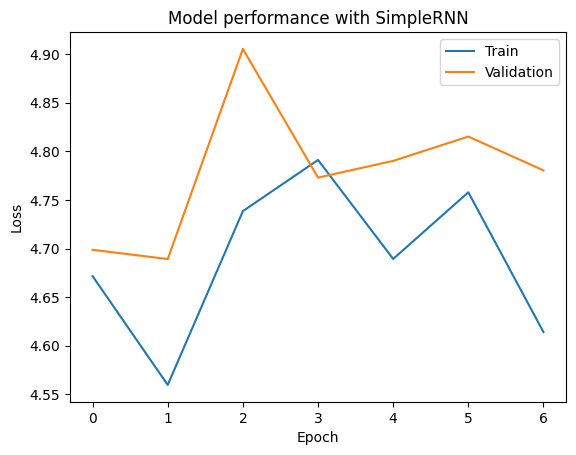

In [ ]:
# Show the model's loss value over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model performance with SimpleRNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

**Long short-term memory RNN**

In [ ]:
# Build the model architecture
inputs = Input((notes_prior, 3))
rnn = LSTM(128)(inputs)
output_note = Dense(128, name='Pitch')(rnn)
output_dur = Dense(1, name='Duration')(rnn)
output_time_prior = Dense(1, name='Time_From_Prior_Note')(rnn)

# output_layer = [output_note, output_dur, output_time_prior]
output_layer = {
  'Pitch': output_note,
  'Duration': output_dur,
  'Time_From_Prior_Note': output_time_prior,
}
model = Model(inputs, output_layer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_2[0][0]']                
                                                                                                  
 Duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 Pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                            

In [ ]:
# Set up loss functions for each output
# Using SparseCategoricalCrossentropy for pitch because we have more than 2
# possibles outputs for pitch (aka notes)
loss_fcns = {'Pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             'Duration': mse_with_positive_pressure,
             'Time_From_Prior_Note': mse_with_positive_pressure}

In [ ]:
# Compile model using Adam optimizer
optimizer = Adam(learning_rate=0.005)
model.compile(loss=loss_fcns, optimizer=optimizer)

In [ ]:
# Evaluate model on individual training set
# to see how well the model would perform on different "emotion" category
# Here, we will test subset "Q1"
losses = model.evaluate(train_set[0], return_dict=True)
losses

940/940 [==============================] - 4s 3ms/step - loss: 7.0253 - Duration_loss: 1.1284 - Pitch_loss: 4.8532 - Time_From_Prior_Note_loss: 1.0438


{'loss': 7.025333404541016,
 'Duration_loss': 1.1283526420593262,
 'Pitch_loss': 4.853227138519287,
 'Time_From_Prior_Note_loss': 1.0437532663345337}

In [ ]:
# Creating a callback function to save checkpoints and weights
# Also incorporate early stopping to monitor the model training process
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
# Train model and visualize the training result
%%time
epochs = 10

history = model.fit(
    train_set[0],
    validation_data = valid_set[0],
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10
940/940 [==============================] - 10s 5ms/step - loss: 4.4864 - Duration_loss: 0.0261 - Pitch_loss: 4.0506 - Time_From_Prior_Note_loss: 0.4097 - val_loss: 4.6050 - val_Duration_loss: 0.0160 - val_Pitch_loss: 4.0252 - val_Time_From_Prior_Note_loss: 0.5638
Epoch 2/10
940/940 [==============================] - 7s 7ms/step - loss: 4.3988 - Duration_loss: 0.0203 - Pitch_loss: 3.9811 - Time_From_Prior_Note_loss: 0.3974 - val_loss: 4.5517 - val_Duration_loss: 0.0158 - val_Pitch_loss: 3.9760 - val_Time_From_Prior_Note_loss: 0.5599
Epoch 3/10
940/940 [==============================] - 6s 6ms/step - loss: 4.3466 - Duration_loss: 0.0199 - Pitch_loss: 3.9341 - Time_From_Prior_Note_loss: 0.3925 - val_loss: 4.5574 - val_Duration_loss: 0.0158 - val_Pitch_loss: 3.9824 - val_Time_From_Prior_Note_loss: 0.5592
Epoch 4/10
940/940 [==============================] - 6s 6ms/step - loss: 4.2944 - Duration_loss: 0.0197 - Pitch_loss: 3.8848 - Time_From_Prior_Note_loss: 0.3899 - val_loss: 4.5

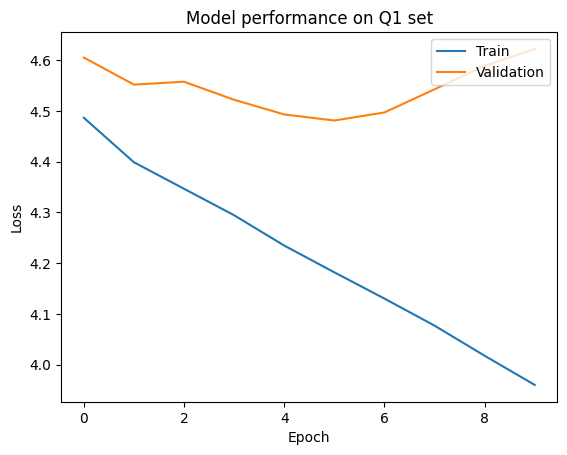

In [ ]:
# Show the model's loss value over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model performance on Q1 set')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Training the model on remaining datasets

In [ ]:
# Dataset 2 (Q2)

In [ ]:
# Evaluate model on individual training set Q2
losses = model.evaluate(train_set[1], return_dict=True)
losses

1300/1300 [==============================] - 17s 3ms/step - loss: 4.6124 - Duration_loss: 0.0152 - Pitch_loss: 4.1234 - Time_From_Prior_Note_loss: 0.4739


{'loss': 4.612442493438721,
 'Duration_loss': 0.015156891196966171,
 'Pitch_loss': 4.1234049797058105,
 'Time_From_Prior_Note_loss': 0.47388187050819397}

Epoch 1/10
1300/1300 [==============================] - 9s 7ms/step - loss: 4.2282 - Duration_loss: 0.0125 - Pitch_loss: 3.7644 - Time_From_Prior_Note_loss: 0.4513 - val_loss: 4.2592 - val_Duration_loss: 0.0152 - val_Pitch_loss: 3.7492 - val_Time_From_Prior_Note_loss: 0.4948
Epoch 2/10
1300/1300 [==============================] - 9s 7ms/step - loss: 4.1100 - Duration_loss: 0.0127 - Pitch_loss: 3.6546 - Time_From_Prior_Note_loss: 0.4427 - val_loss: 4.2632 - val_Duration_loss: 0.0152 - val_Pitch_loss: 3.7520 - val_Time_From_Prior_Note_loss: 0.4960
Epoch 3/10
1300/1300 [==============================] - 9s 7ms/step - loss: 4.0133 - Duration_loss: 0.0130 - Pitch_loss: 3.5666 - Time_From_Prior_Note_loss: 0.4338 - val_loss: 4.2843 - val_Duration_loss: 0.0150 - val_Pitch_loss: 3.7728 - val_Time_From_Prior_Note_loss: 0.4966
Epoch 4/10
1300/1300 [==============================] - 7s 6ms/step - loss: 3.9222 - Duration_loss: 0.0133 - Pitch_loss: 3.4844 - Time_From_Prior_Note_loss: 0.4244 - val_lo

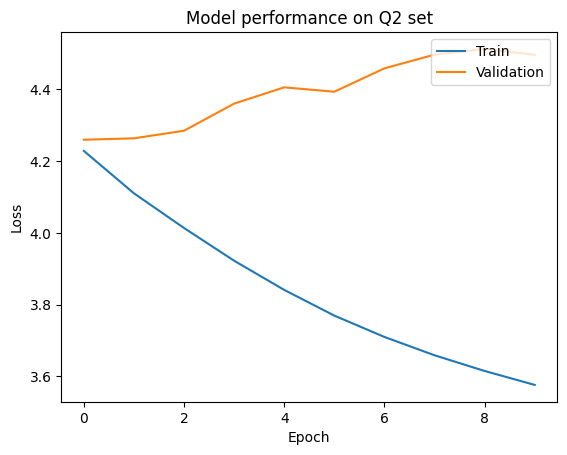

CPU times: user 1min 32s, sys: 5.62 s, total: 1min 37s
Wall time: 1min 26s


In [ ]:
# Train model and visualize the training result
%%time
epochs = 10

history = model.fit(
    train_set[1],
    validation_data = valid_set[1],
    epochs=epochs,
    callbacks=callbacks,
)

# Show the model's loss value over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model performance on Q2 set')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Dataset 3 (Q3)

# Evaluate model on individual training set Q3
losses = model.evaluate(train_set[2], return_dict=True)
losses

656/656 [==============================] - 8s 4ms/step - loss: 5.7178 - Duration_loss: 0.0734 - Pitch_loss: 4.1994 - Time_From_Prior_Note_loss: 1.4449


{'loss': 5.717794418334961,
 'Duration_loss': 0.07344147562980652,
 'Pitch_loss': 4.199409484863281,
 'Time_From_Prior_Note_loss': 1.4449405670166016}

Epoch 1/10
656/656 [==============================] - 6s 8ms/step - loss: 4.9178 - Duration_loss: 0.0664 - Pitch_loss: 3.5826 - Time_From_Prior_Note_loss: 1.2687 - val_loss: 5.1589 - val_Duration_loss: 0.2048 - val_Pitch_loss: 3.7364 - val_Time_From_Prior_Note_loss: 1.2177
Epoch 2/10
656/656 [==============================] - 4s 6ms/step - loss: 4.7280 - Duration_loss: 0.0659 - Pitch_loss: 3.4283 - Time_From_Prior_Note_loss: 1.2338 - val_loss: 5.1931 - val_Duration_loss: 0.2056 - val_Pitch_loss: 3.7746 - val_Time_From_Prior_Note_loss: 1.2129
Epoch 3/10
656/656 [==============================] - 4s 7ms/step - loss: 4.6261 - Duration_loss: 0.0658 - Pitch_loss: 3.3438 - Time_From_Prior_Note_loss: 1.2165 - val_loss: 5.2522 - val_Duration_loss: 0.2066 - val_Pitch_loss: 3.8300 - val_Time_From_Prior_Note_loss: 1.2156
Epoch 4/10
656/656 [==============================] - 5s 7ms/step - loss: 4.5328 - Duration_loss: 0.0661 - Pitch_loss: 3.2716 - Time_From_Prior_Note_loss: 1.1951 - val_loss: 5.33

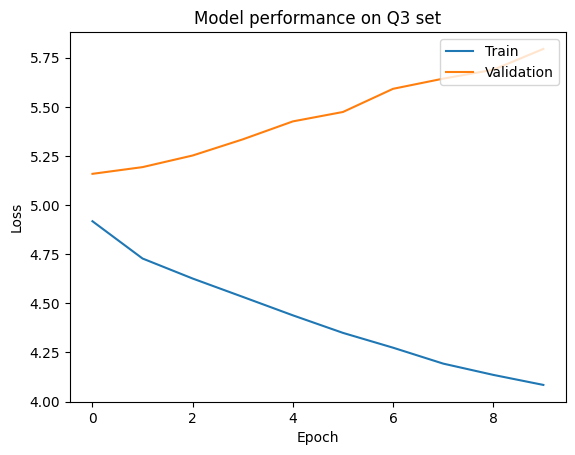

CPU times: user 47.3 s, sys: 2.88 s, total: 50.2 s
Wall time: 47.4 s


In [ ]:
# Train model and visualize the training result
%%time
epochs = 10

history = model.fit(
    train_set[2],
    validation_data = valid_set[2],
    epochs=epochs,
    callbacks=callbacks,
)

# Show the model's loss value over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model performance on Q3 set')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Dataset 4 (Q4)

# Evaluate model on individual training set Q4
losses = model.evaluate(train_set[3], return_dict=True)
losses

760/760 [==============================] - 9s 4ms/step - loss: 5.1749 - Duration_loss: 0.0543 - Pitch_loss: 4.1404 - Time_From_Prior_Note_loss: 0.9802


{'loss': 5.174918174743652,
 'Duration_loss': 0.054306916892528534,
 'Pitch_loss': 4.140432357788086,
 'Time_From_Prior_Note_loss': 0.9801820516586304}

Epoch 1/10
760/760 [==============================] - 5s 7ms/step - loss: 4.5359 - Duration_loss: 0.0512 - Pitch_loss: 3.6116 - Time_From_Prior_Note_loss: 0.8731 - val_loss: 4.6471 - val_Duration_loss: 0.0758 - val_Pitch_loss: 3.6541 - val_Time_From_Prior_Note_loss: 0.9172
Epoch 2/10
760/760 [==============================] - 4s 6ms/step - loss: 4.4085 - Duration_loss: 0.0510 - Pitch_loss: 3.5084 - Time_From_Prior_Note_loss: 0.8491 - val_loss: 4.6498 - val_Duration_loss: 0.0757 - val_Pitch_loss: 3.6628 - val_Time_From_Prior_Note_loss: 0.9113
Epoch 3/10
760/760 [==============================] - 6s 7ms/step - loss: 4.3363 - Duration_loss: 0.0511 - Pitch_loss: 3.4488 - Time_From_Prior_Note_loss: 0.8364 - val_loss: 4.6988 - val_Duration_loss: 0.0758 - val_Pitch_loss: 3.7079 - val_Time_From_Prior_Note_loss: 0.9151
Epoch 4/10
760/760 [==============================] - 4s 6ms/step - loss: 4.2652 - Duration_loss: 0.0511 - Pitch_loss: 3.3926 - Time_From_Prior_Note_loss: 0.8215 - val_loss: 4.78

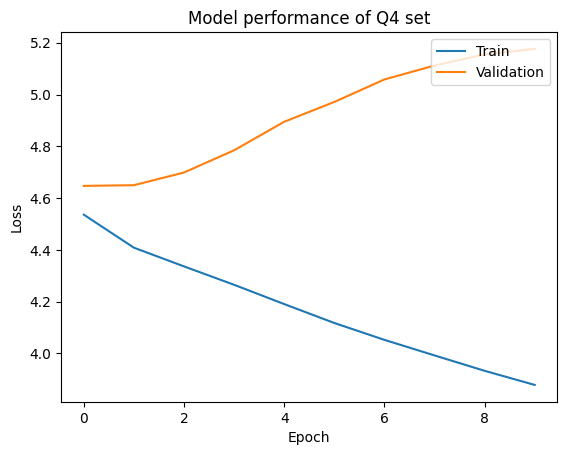

CPU times: user 53.7 s, sys: 3.03 s, total: 56.7 s
Wall time: 56.8 s


In [ ]:
# Train model and visualize the training result
%%time
epochs = 10

history = model.fit(
    train_set[3],
    validation_data = valid_set[3],
    epochs=epochs,
    callbacks=callbacks,
)

# Show the model's loss value over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model performance of Q4 set')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Tuning model optimizers

**Nadam**

In [ ]:
### Testing different optimizer ###
### optimizers = [SGD, Adam, RMSprop, Nadam]

# Training model with Nadam optimizer
# Build the model arhitecture
inputs = Input((notes_prior, 3))
rnn = LSTM(128)(inputs)
output_note = Dense(128, name='Pitch')(rnn)
output_dur = Dense(1, name='Duration')(rnn)
output_time_prior = Dense(1, name='Time_From_Prior_Note')(rnn)

# output_layer = [output_note, output_dur, output_time_prior]
output_layer = {
  'Pitch': output_note,
  'Duration': output_dur,
  'Time_From_Prior_Note': output_time_prior,
}
model = Model(inputs, output_layer)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          67584       ['input_3[0][0]']                
                                                                                                  
 Duration (Dense)               (None, 1)            129         ['lstm_1[0][0]']                 
                                                                                                  
 Pitch (Dense)                  (None, 128)          16512       ['lstm_1[0][0]']                 
                                                                                            

In [ ]:
loss_fcns = {'Pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             'Duration': mse_with_positive_pressure,
             'Time_From_Prior_Note': mse_with_positive_pressure}

In [ ]:
optimizer = Nadam(learning_rate=0.005)
model.compile(loss=loss_fcns, optimizer=optimizer)

In [ ]:
# Evaluate model on individual training set 1
losses = model.evaluate(train_set[0], return_dict=True)
losses

940/940 [==============================] - 4s 3ms/step - loss: 5.8221 - Duration_loss: 0.0662 - Pitch_loss: 4.8449 - Time_From_Prior_Note_loss: 0.9110


{'loss': 5.822055816650391,
 'Duration_loss': 0.0661749467253685,
 'Pitch_loss': 4.844911098480225,
 'Time_From_Prior_Note_loss': 0.9109674692153931}

Epoch 1/10
940/940 [==============================] - 10s 7ms/step - loss: 4.4764 - Duration_loss: 0.0235 - Pitch_loss: 4.0444 - Time_From_Prior_Note_loss: 0.4085 - val_loss: 4.5887 - val_Duration_loss: 0.0159 - val_Pitch_loss: 4.0066 - val_Time_From_Prior_Note_loss: 0.5662
Epoch 2/10
940/940 [==============================] - 6s 7ms/step - loss: 4.3813 - Duration_loss: 0.0203 - Pitch_loss: 3.9632 - Time_From_Prior_Note_loss: 0.3978 - val_loss: 4.5528 - val_Duration_loss: 0.0156 - val_Pitch_loss: 3.9742 - val_Time_From_Prior_Note_loss: 0.5630
Epoch 3/10
940/940 [==============================] - 7s 8ms/step - loss: 4.3290 - Duration_loss: 0.0198 - Pitch_loss: 3.9159 - Time_From_Prior_Note_loss: 0.3933 - val_loss: 4.5405 - val_Duration_loss: 0.0156 - val_Pitch_loss: 3.9605 - val_Time_From_Prior_Note_loss: 0.5645
Epoch 4/10
940/940 [==============================] - 6s 6ms/step - loss: 4.2677 - Duration_loss: 0.0198 - Pitch_loss: 3.8580 - Time_From_Prior_Note_loss: 0.3898 - val_loss: 4.4

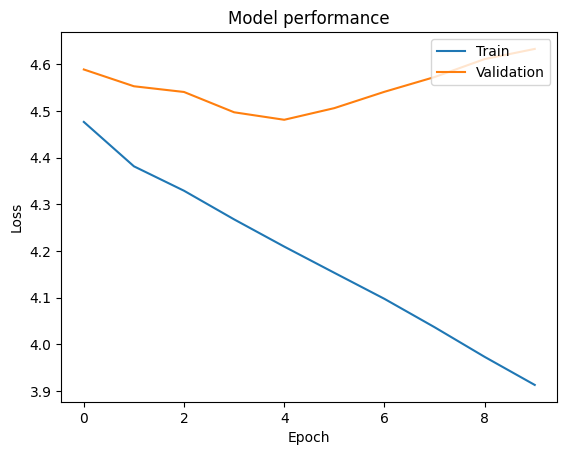

CPU times: user 1min 13s, sys: 4.47 s, total: 1min 17s
Wall time: 1min 16s


In [ ]:
# Train model and visualize the training result
%%time
epochs = 10

history = model.fit(
    train_set[0],
    validation_data = valid_set[0],
    epochs=epochs,
    callbacks=callbacks,
)

# Show the model's loss value over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

**Stochastic Gradient Descent (SGD)**

In [ ]:
# Training model with SGD optimizer
optimizer = SGD(learning_rate=0.005)

model.compile(loss=loss_fcns, optimizer=optimizer)

In [ ]:
# Evaluate model on individual training set 1
losses = model.evaluate(train_set[0], return_dict=True)
losses

940/940 [==============================] - 4s 3ms/step - loss: 3.8897 - Duration_loss: 0.0207 - Pitch_loss: 3.5080 - Time_From_Prior_Note_loss: 0.3610


{'loss': 3.8896872997283936,
 'Duration_loss': 0.02074377052485943,
 'Pitch_loss': 3.507969856262207,
 'Time_From_Prior_Note_loss': 0.3609746992588043}

Epoch 1/10
940/940 [==============================] - 8s 7ms/step - loss: 3.8499 - Duration_loss: 0.0200 - Pitch_loss: 3.4734 - Time_From_Prior_Note_loss: 0.3565 - val_loss: 4.6573 - val_Duration_loss: 0.0158 - val_Pitch_loss: 4.0471 - val_Time_From_Prior_Note_loss: 0.5945
Epoch 2/10
940/940 [==============================] - 5s 6ms/step - loss: 3.8217 - Duration_loss: 0.0195 - Pitch_loss: 3.4497 - Time_From_Prior_Note_loss: 0.3525 - val_loss: 4.6608 - val_Duration_loss: 0.0155 - val_Pitch_loss: 4.0552 - val_Time_From_Prior_Note_loss: 0.5901
Epoch 3/10
940/940 [==============================] - 7s 7ms/step - loss: 3.8087 - Duration_loss: 0.0193 - Pitch_loss: 3.4389 - Time_From_Prior_Note_loss: 0.3504 - val_loss: 4.6628 - val_Duration_loss: 0.0154 - val_Pitch_loss: 4.0589 - val_Time_From_Prior_Note_loss: 0.5885
Epoch 4/10
940/940 [==============================] - 5s 5ms/step - loss: 3.7998 - Duration_loss: 0.0192 - Pitch_loss: 3.4316 - Time_From_Prior_Note_loss: 0.3491 - val_loss: 4.66

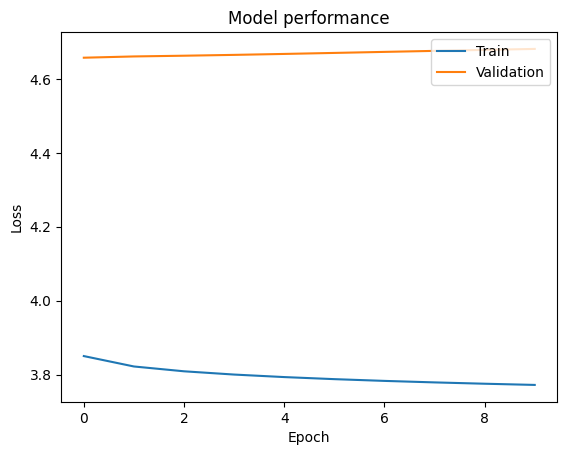

CPU times: user 1min 4s, sys: 3.6 s, total: 1min 8s
Wall time: 1min 17s


In [ ]:
# Train model and visualize the training result
%%time
epochs = 10

history = model.fit(
    train_set[0],
    validation_data = valid_set[0],
    epochs=epochs,
    callbacks=callbacks,
)

# Show the model's loss value over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

**RMSprop**

In [ ]:
# Training model with RMSprop optimizer
optimizer = RMSprop(learning_rate=0.005)

model.compile(loss=loss_fcns, optimizer=optimizer)

In [ ]:
# Evaluate model on individual training set 1
losses = model.evaluate(train_set[0], return_dict=True)
losses

940/940 [==============================] - 4s 3ms/step - loss: 3.7715 - Duration_loss: 0.0190 - Pitch_loss: 3.4076 - Time_From_Prior_Note_loss: 0.3448


{'loss': 3.771458864212036,
 'Duration_loss': 0.019001025706529617,
 'Pitch_loss': 3.407641887664795,
 'Time_From_Prior_Note_loss': 0.34481579065322876}

Epoch 1/10
940/940 [==============================] - 8s 6ms/step - loss: 3.8425 - Duration_loss: 0.0203 - Pitch_loss: 3.4755 - Time_From_Prior_Note_loss: 0.3467 - val_loss: 4.6775 - val_Duration_loss: 0.0157 - val_Pitch_loss: 4.0523 - val_Time_From_Prior_Note_loss: 0.6095
Epoch 2/10
940/940 [==============================] - 5s 6ms/step - loss: 3.8039 - Duration_loss: 0.0207 - Pitch_loss: 3.4434 - Time_From_Prior_Note_loss: 0.3398 - val_loss: 4.7454 - val_Duration_loss: 0.0176 - val_Pitch_loss: 4.1062 - val_Time_From_Prior_Note_loss: 0.6216
Epoch 3/10
940/940 [==============================] - 6s 7ms/step - loss: 3.7793 - Duration_loss: 0.0210 - Pitch_loss: 3.4205 - Time_From_Prior_Note_loss: 0.3378 - val_loss: 4.7668 - val_Duration_loss: 0.0168 - val_Pitch_loss: 4.1233 - val_Time_From_Prior_Note_loss: 0.6267
Epoch 4/10
940/940 [==============================] - 5s 6ms/step - loss: 3.7524 - Duration_loss: 0.0211 - Pitch_loss: 3.3980 - Time_From_Prior_Note_loss: 0.3334 - val_loss: 4.79

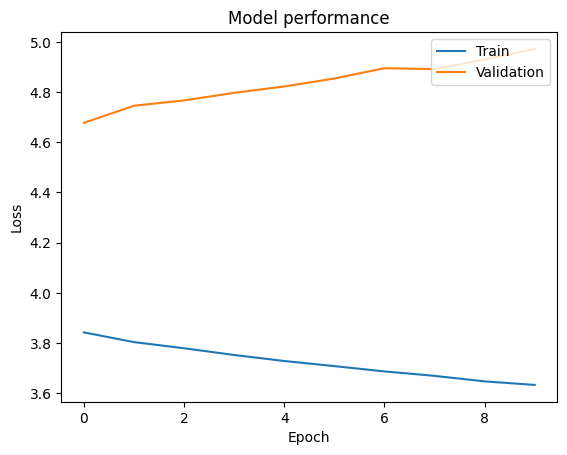

CPU times: user 1min 5s, sys: 3.79 s, total: 1min 9s
Wall time: 1min 29s


In [ ]:
# Train model and visualize the training result
%%time
epochs = 10

history = model.fit(
    train_set[0],
    validation_data = valid_set[0],
    epochs=epochs,
    callbacks=callbacks,
)

# Show the model's loss value over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Comments: Of the 4 tested optimizers, SGD appears to performe the best. So, we will continue tuning the model using this optimizer.

# Tuning the learning rate


In [ ]:
# Calling model again
inputs = Input((notes_prior, 3))
rnn = LSTM(128)(inputs)
output_note = Dense(128, name='Pitch')(rnn)
output_dur = Dense(1, name='Duration')(rnn)
output_time_prior = Dense(1, name='Time_From_Prior_Note')(rnn)

# output_layer = [output_note, output_dur, output_time_prior]
output_layer = {
  'Pitch': output_note,
  'Duration': output_dur,
  'Time_From_Prior_Note': output_time_prior,
}
model = Model(inputs, output_layer)

loss_fcns = {'Pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             'Duration': mse_with_positive_pressure,
             'Time_From_Prior_Note': mse_with_positive_pressure}

optimizer = SGD(learning_rate=0.01)
model.compile(loss=loss_fcns, optimizer=optimizer)

In [ ]:
losses = model.evaluate(train_set[0], return_dict=True)
losses

940/940 [==============================] - 4s 3ms/step - loss: 5.8631 - Duration_loss: 0.1329 - Pitch_loss: 4.8497 - Time_From_Prior_Note_loss: 0.8806


{'loss': 5.86309289932251,
 'Duration_loss': 0.13285498321056366,
 'Pitch_loss': 4.849662780761719,
 'Time_From_Prior_Note_loss': 0.8805707097053528}

**lr=0.01**

In [ ]:
# Train model  and visualize the training result
%%time
epochs = 10

history = model.fit(
    train_set[0],
    validation_data = valid_set[0],
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10
940/940 [==============================] - 8s 7ms/step - loss: 4.9641 - Duration_loss: 0.0225 - Pitch_loss: 4.5162 - Time_From_Prior_Note_loss: 0.4254 - val_loss: 4.7396 - val_Duration_loss: 0.0171 - val_Pitch_loss: 4.1508 - val_Time_From_Prior_Note_loss: 0.5718
Epoch 2/10
940/940 [==============================] - 5s 6ms/step - loss: 4.5435 - Duration_loss: 0.0216 - Pitch_loss: 4.1067 - Time_From_Prior_Note_loss: 0.4152 - val_loss: 4.6370 - val_Duration_loss: 0.0168 - val_Pitch_loss: 4.0439 - val_Time_From_Prior_Note_loss: 0.5763
Epoch 3/10
940/940 [==============================] - 6s 7ms/step - loss: 4.4981 - Duration_loss: 0.0226 - Pitch_loss: 4.0615 - Time_From_Prior_Note_loss: 0.4141 - val_loss: 4.6191 - val_Duration_loss: 0.0166 - val_Pitch_loss: 4.0246 - val_Time_From_Prior_Note_loss: 0.5779
Epoch 4/10
940/940 [==============================] - 5s 6ms/step - loss: 4.4843 - Duration_loss: 0.0222 - Pitch_loss: 4.0485 - Time_From_Prior_Note_loss: 0.4136 - val_loss: 4.61

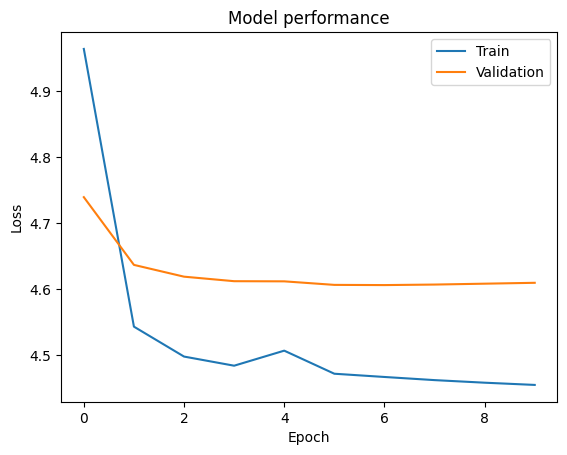

In [ ]:
# Show the model's loss value over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

**lr=0.05**

In [ ]:
optimizer = SGD(learning_rate=0.05)
model.compile(loss=loss_fcns, optimizer=optimizer)

In [ ]:
losses = model.evaluate(train_set[0], return_dict=True)
losses

940/940 [==============================] - 4s 3ms/step - loss: 4.4539 - Duration_loss: 0.0209 - Pitch_loss: 4.0256 - Time_From_Prior_Note_loss: 0.4074


{'loss': 4.453897953033447,
 'Duration_loss': 0.020929628983139992,
 'Pitch_loss': 4.025616645812988,
 'Time_From_Prior_Note_loss': 0.40735384821891785}

In [ ]:
# Train model and visualize the training result
%%time
epochs = 10

history = model.fit(
    train_set[0],
    validation_data = valid_set[0],
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10
940/940 [==============================] - 8s 6ms/step - loss: 5.4726 - Duration_loss: 0.1137 - Pitch_loss: 4.2798 - Time_From_Prior_Note_loss: 1.0791 - val_loss: 4.6487 - val_Duration_loss: 0.0167 - val_Pitch_loss: 4.0512 - val_Time_From_Prior_Note_loss: 0.5809
Epoch 2/10
940/940 [==============================] - 6s 7ms/step - loss: 4.5495 - Duration_loss: 0.0560 - Pitch_loss: 4.0664 - Time_From_Prior_Note_loss: 0.4272 - val_loss: 4.6225 - val_Duration_loss: 0.0164 - val_Pitch_loss: 4.0302 - val_Time_From_Prior_Note_loss: 0.5759
Epoch 3/10
940/940 [==============================] - 6s 6ms/step - loss: 4.4798 - Duration_loss: 0.0219 - Pitch_loss: 4.0393 - Time_From_Prior_Note_loss: 0.4186 - val_loss: 4.6152 - val_Duration_loss: 0.0165 - val_Pitch_loss: 4.0214 - val_Time_From_Prior_Note_loss: 0.5772
Epoch 4/10
940/940 [==============================] - 6s 6ms/step - loss: 4.4663 - Duration_loss: 0.0218 - Pitch_loss: 4.0272 - Time_From_Prior_Note_loss: 0.4173 - val_loss: 4.61

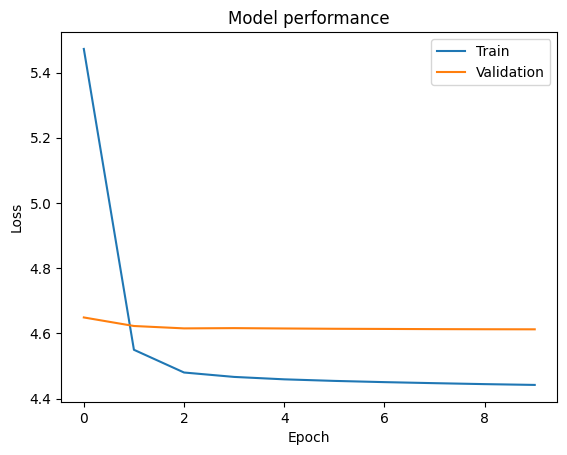

In [ ]:
# Show the model's loss value over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

**lr=0.001**

In [ ]:
optimizer = SGD(learning_rate=0.001)
model.compile(loss=loss_fcns, optimizer=optimizer)

In [ ]:
losses = model.evaluate(train_set[0], return_dict=True)
losses

940/940 [==============================] - 4s 3ms/step - loss: 4.4347 - Duration_loss: 0.0211 - Pitch_loss: 4.0106 - Time_From_Prior_Note_loss: 0.4030


{'loss': 4.434726238250732,
 'Duration_loss': 0.021079204976558685,
 'Pitch_loss': 4.010621547698975,
 'Time_From_Prior_Note_loss': 0.4030243158340454}

In [ ]:
# Train model and visualize the training result
%%time
epochs = 10

history = model.fit(
    train_set[0],
    validation_data = valid_set[0],
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10
940/940 [==============================] - 8s 6ms/step - loss: 4.4261 - Duration_loss: 0.0209 - Pitch_loss: 4.0103 - Time_From_Prior_Note_loss: 0.3950 - val_loss: 4.6047 - val_Duration_loss: 0.0162 - val_Pitch_loss: 4.0147 - val_Time_From_Prior_Note_loss: 0.5737
Epoch 2/10
940/940 [==============================] - 6s 7ms/step - loss: 4.4250 - Duration_loss: 0.0208 - Pitch_loss: 4.0096 - Time_From_Prior_Note_loss: 0.3946 - val_loss: 4.6034 - val_Duration_loss: 0.0162 - val_Pitch_loss: 4.0130 - val_Time_From_Prior_Note_loss: 0.5742
Epoch 3/10
940/940 [==============================] - 6s 6ms/step - loss: 4.4245 - Duration_loss: 0.0208 - Pitch_loss: 4.0091 - Time_From_Prior_Note_loss: 0.3945 - val_loss: 4.6022 - val_Duration_loss: 0.0162 - val_Pitch_loss: 4.0117 - val_Time_From_Prior_Note_loss: 0.5743
Epoch 4/10
940/940 [==============================] - 7s 7ms/step - loss: 4.4241 - Duration_loss: 0.0208 - Pitch_loss: 4.0088 - Time_From_Prior_Note_loss: 0.3945 - val_loss: 4.60

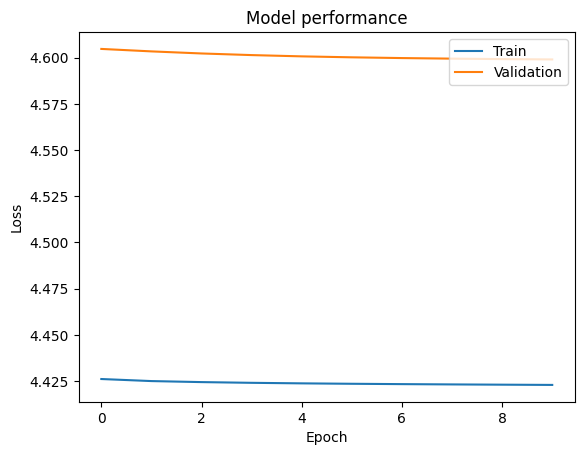

In [ ]:
# Show the model's loss value over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Rerun best model

### Emotion Q1

In [ ]:
# Calling best model
notes_prior = 25
inputs = Input((notes_prior, 3))
rnn = LSTM(128)(inputs)
output_note = Dense(128, name='Pitch')(rnn)
output_dur = Dense(1, name='Duration')(rnn)
output_time_prior = Dense(1, name='Time_From_Prior_Note')(rnn)

# output_layer = [output_note, output_dur, output_time_prior]
output_layer = {
  'Pitch': output_note,
  'Duration': output_dur,
  'Time_From_Prior_Note': output_time_prior,
}
model_Q1 = Model(inputs, output_layer)

loss_fcns = {'Pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             'Duration': mse_with_positive_pressure,
             'Time_From_Prior_Note': mse_with_positive_pressure}

optimizer = SGD(learning_rate=0.005)
model_Q1.compile(loss=loss_fcns, optimizer=optimizer)

In [ ]:
# Train model on emotion Q1
%%time
epochs = 20

history_Q1 = model_Q1.fit(
    train_set[0],
    validation_data = valid_set[0],
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/20
940/940 [==============================] - 9s 6ms/step - loss: 5.1888 - Duration_loss: 0.0211 - Pitch_loss: 4.7315 - Time_From_Prior_Note_loss: 0.4363 - val_loss: 5.1309 - val_Duration_loss: 0.0165 - val_Pitch_loss: 4.5472 - val_Time_From_Prior_Note_loss: 0.5673
Epoch 2/20
940/940 [==============================] - 6s 7ms/step - loss: 4.7772 - Duration_loss: 0.0210 - Pitch_loss: 4.3386 - Time_From_Prior_Note_loss: 0.4176 - val_loss: 4.7541 - val_Duration_loss: 0.0166 - val_Pitch_loss: 4.1717 - val_Time_From_Prior_Note_loss: 0.5659
Epoch 3/20
940/940 [==============================] - 7s 7ms/step - loss: 4.5706 - Duration_loss: 0.0211 - Pitch_loss: 4.1381 - Time_From_Prior_Note_loss: 0.4114 - val_loss: 4.6621 - val_Duration_loss: 0.0166 - val_Pitch_loss: 4.0762 - val_Time_From_Prior_Note_loss: 0.5693
Epoch 4/20
940/940 [==============================] - 7s 8ms/step - loss: 4.5168 - Duration_loss: 0.0211 - Pitch_loss: 4.0865 - Time_From_Prior_Note_loss: 0.4092 - val_loss: 4.63

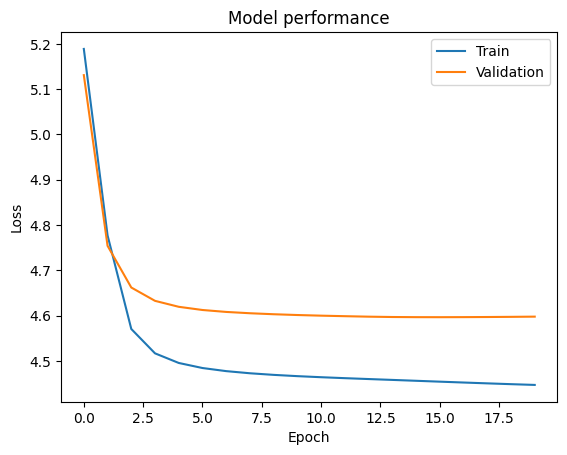

In [ ]:
# Show the model's loss value over epochs
plt.plot(history_Q1.history['loss'])
plt.plot(history_Q1.history['val_loss'])
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Emotion Q2

In [ ]:
model_Q2 = Model(inputs, output_layer)
model_Q2.compile(loss=loss_fcns, optimizer=optimizer)

In [ ]:
# Train model on emotion Q2
%%time
epochs = 20

history_Q2 = model_Q2.fit(
    train_set[1],
    validation_data = valid_set[1],
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/20
1300/1300 [==============================] - 11s 6ms/step - loss: 4.4920 - Duration_loss: 0.0137 - Pitch_loss: 4.0188 - Time_From_Prior_Note_loss: 0.4594 - val_loss: 4.4407 - val_Duration_loss: 0.0152 - val_Pitch_loss: 3.9221 - val_Time_From_Prior_Note_loss: 0.5034
Epoch 2/20
1300/1300 [==============================] - 9s 7ms/step - loss: 4.4507 - Duration_loss: 0.0130 - Pitch_loss: 3.9811 - Time_From_Prior_Note_loss: 0.4566 - val_loss: 4.4310 - val_Duration_loss: 0.0152 - val_Pitch_loss: 3.9113 - val_Time_From_Prior_Note_loss: 0.5045
Epoch 3/20
1300/1300 [==============================] - 13s 10ms/step - loss: 4.4375 - Duration_loss: 0.0129 - Pitch_loss: 3.9683 - Time_From_Prior_Note_loss: 0.4563 - val_loss: 4.4247 - val_Duration_loss: 0.0151 - val_Pitch_loss: 3.9039 - val_Time_From_Prior_Note_loss: 0.5057
Epoch 4/20
1300/1300 [==============================] - 8s 6ms/step - loss: 4.4297 - Duration_loss: 0.0129 - Pitch_loss: 3.9607 - Time_From_Prior_Note_loss: 0.4561 - val

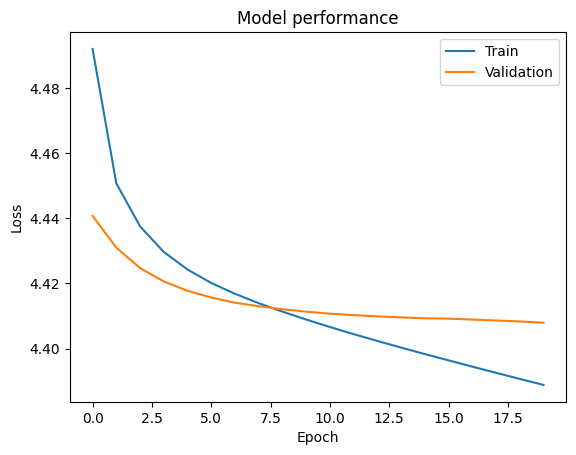

In [ ]:
# Show the model's loss value over epochs
plt.plot(history_Q2.history['loss'])
plt.plot(history_Q2.history['val_loss'])
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Emotion Q3

In [ ]:
model_Q3 = Model(inputs, output_layer)
model_Q3.compile(loss=loss_fcns, optimizer=optimizer)

In [ ]:
# Train model on emotion Q3
%%time
epochs = 20

history_Q3 = model_Q3.fit(
    train_set[2],
    validation_data = valid_set[2],
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/20
656/656 [==============================] - 7s 8ms/step - loss: 5.0993 - Duration_loss: 0.0694 - Pitch_loss: 3.7542 - Time_From_Prior_Note_loss: 1.2757 - val_loss: 5.2474 - val_Duration_loss: 0.2067 - val_Pitch_loss: 3.8146 - val_Time_From_Prior_Note_loss: 1.2262
Epoch 2/20
656/656 [==============================] - 4s 6ms/step - loss: 5.0501 - Duration_loss: 0.0682 - Pitch_loss: 3.7118 - Time_From_Prior_Note_loss: 1.2701 - val_loss: 5.2456 - val_Duration_loss: 0.2059 - val_Pitch_loss: 3.8136 - val_Time_From_Prior_Note_loss: 1.2261
Epoch 3/20
656/656 [==============================] - 4s 7ms/step - loss: 5.0312 - Duration_loss: 0.0675 - Pitch_loss: 3.6963 - Time_From_Prior_Note_loss: 1.2674 - val_loss: 5.2442 - val_Duration_loss: 0.2052 - val_Pitch_loss: 3.8143 - val_Time_From_Prior_Note_loss: 1.2247
Epoch 4/20
656/656 [==============================] - 5s 7ms/step - loss: 5.0193 - Duration_loss: 0.0673 - Pitch_loss: 3.6863 - Time_From_Prior_Note_loss: 1.2657 - val_loss: 5.24

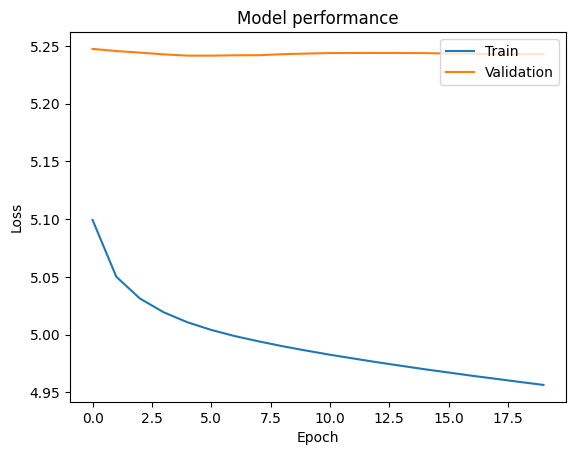

In [ ]:
# Show the model's loss value over epochs
plt.plot(history_Q3.history['loss'])
plt.plot(history_Q3.history['val_loss'])
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Emotion Q4

In [ ]:
model_Q4 = Model(inputs, output_layer)
model_Q4.compile(loss=loss_fcns, optimizer=optimizer)

In [ ]:
# Train model on emotion Q4
%%time
epochs = 20

history_Q4 = model_Q4.fit(
    train_set[3],
    validation_data = valid_set[3],
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/20
760/760 [==============================] - 6s 6ms/step - loss: 4.6533 - Duration_loss: 0.0525 - Pitch_loss: 3.7192 - Time_From_Prior_Note_loss: 0.8816 - val_loss: 4.7728 - val_Duration_loss: 0.0768 - val_Pitch_loss: 3.7795 - val_Time_From_Prior_Note_loss: 0.9165
Epoch 2/20
760/760 [==============================] - 5s 7ms/step - loss: 4.6335 - Duration_loss: 0.0524 - Pitch_loss: 3.7014 - Time_From_Prior_Note_loss: 0.8797 - val_loss: 4.7666 - val_Duration_loss: 0.0768 - val_Pitch_loss: 3.7747 - val_Time_From_Prior_Note_loss: 0.9151
Epoch 3/20
760/760 [==============================] - 5s 6ms/step - loss: 4.6260 - Duration_loss: 0.0521 - Pitch_loss: 3.6952 - Time_From_Prior_Note_loss: 0.8786 - val_loss: 4.7618 - val_Duration_loss: 0.0769 - val_Pitch_loss: 3.7704 - val_Time_From_Prior_Note_loss: 0.9145
Epoch 4/20
760/760 [==============================] - 5s 6ms/step - loss: 4.6208 - Duration_loss: 0.0520 - Pitch_loss: 3.6909 - Time_From_Prior_Note_loss: 0.8779 - val_loss: 4.75

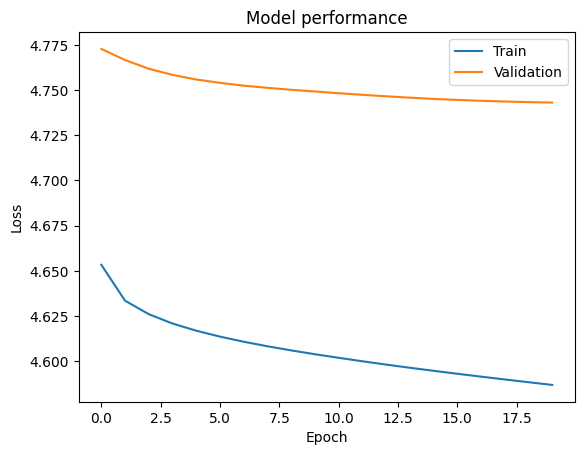

In [ ]:
# Show the model's loss value over epochs
plt.plot(history_Q4.history['loss'])
plt.plot(history_Q4.history['val_loss'])
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Make Music

In [ ]:
def generate_midi(notes, out_file, instrument_name, velocity= 100):
  """
  This function recieves a dataframe file and generates a MIDI file from it
  """
  midi_result = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))

  prev_note_start = 0
  for i, note in notes.iterrows():
    start = float(prev_note_start + note['Time_From_Prior_Note'])
    end = float(start + note['Duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['Pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_note_start = start

  midi_result.instruments.append(instrument)
  midi_result.write(out_file)
  return midi_result

In [ ]:
def predict_next_note(notes, model, temperature=1.0):
  """
  To generate music, first we will provide a starting sequence of notes. This function generates one note from a sequence of given notes.
  """
  """Generates a note as a tuple of (pitch, step, duration),
  using a trained sequence model."""

  # The temperature parameter can be used to control the randomness of notes generated.
  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['Pitch']
  time_from_prior_note = predictions['Time_From_Prior_Note']
  duration = predictions['Duration']

  pitch_logits /= temperature
  """For note pitch, we draw a sample from the softmax distribution of notes produced by the model. If we always pick the note
  with the highest probability,, it would lead to repetitive sequences of notes being generated."""
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  time_from_prior_note = tf.squeeze(time_from_prior_note, axis=-1)

  # time_from_prior_note and duration values should be non-negative
  time_from_prior_note = tf.maximum(0, time_from_prior_note)
  duration = tf.maximum(0, duration)

  return int(pitch), float(time_from_prior_note), float(duration)

In [ ]:
def generate_notes(dataset, model, emotion, temperature, num_predictions):
  """
  This function gets the test data and generates a MIDI file using the model we trained
  """
  # The initial sequence of notes; pitch is normalized similar to training
  # sequences
  input_notes = (dataset[emotion][:notes_prior] / np.array([128, 1, 1]))

  generated_notes = []
  prev_note_start = 0
  for i in range(num_predictions):
    pitch, time_from_prior_note, duration = predict_next_note(input_notes, model, temperature)  # Predicting each next note absed on the input note
    this_note_start = prev_note_start + time_from_prior_note
    this_note_end = this_note_start + duration
    input_note = (pitch, time_from_prior_note, duration)
    generated_notes.append((*input_note, this_note_start, this_note_end))
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_note_start = this_note_start

  generated_notes = pd.DataFrame(
      generated_notes, columns=('Pitch', 'Time_From_Prior_Note', 'Duration', 'Start', 'End'))

  out_file = 'output_Q' + str(emotion+1) + '.mid'
  out_pm = generate_midi(generated_notes, out_file=out_file, instrument_name=instrument_name)
  return out_pm

In [ ]:
def make_notes(list_clips, song_details, num_features):
  """
  This function prepares the input data(test clips) for our model
  """
  # create a table for each file
  notes = []
  for clip_file in list_clips:
    song_notes = extract_notes(clip_file)
    notes.append(song_notes)

  # places notes from all songs into a single file
  notes_df = pd.concat(notes)
  notes_df.reset_index(inplace=True, drop=True)
  print('Number of notes: ', notes_df.shape[0])

  # combine emotion data into the dataset
  emotions_df = song_details[['name', 'keyname', '4Q']]
  notes_df = pd.merge(notes_df, emotions_df, how='left', left_on='File Name', right_on='name')
  notes_df.drop(columns=['name'], inplace=True)

  # convert the table to a numpy array
  cols = ['Pitch', 'Duration', 'Time_From_Prior_Note']

  notes = []
  for i in range(1, 5):
    notes.append(notes_df[cols].loc[notes_df[cols+['4Q']]['4Q'] == i])

  return notes

In [ ]:
test_notes = make_notes(test_clips, song_meta_df, notes_prior)

Number of notes:  22340


In [ ]:
def display_audio(pretty_midi, sampling_rate=16000, seconds=30):
  waveform = pretty_midi.fluidsynth(fs=sampling_rate)
  waveform_short = waveform[:seconds*sampling_rate]
  return display.Audio(waveform_short, rate=sampling_rate)

In [ ]:
generated_audio = generate_notes(test_notes, model_Q1, 0, 2, 120)
display_audio(generated_audio)

1/1 [==============================] - 0s 40ms/step


In [ ]:
generated_audio = generate_notes(test_notes, model_Q2, 1, 2, 120)
display_audio(generated_audio)

1/1 [==============================] - 0s 26ms/step


In [ ]:
generated_audio = generate_notes(test_notes, model_Q3, 2, 2, 120)
display_audio(generated_audio)

1/1 [==============================] - 0s 24ms/step


In [ ]:
generated_audio = generate_notes(test_notes, model_Q4, 3, 2, 120)
display_audio(generated_audio)

1/1 [==============================] - 0s 23ms/step


In [ ]:
# Potential datasets
# https://www.kaggle.com/datasets/imsparsh/musicnet-dataset/code
# https://www.kaggle.com/datasets/googleai/musiccaps
# https://www.kaggle.com/datasets/soumikrakshit/classical-music-midi
